In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
from collections import Counter
import os

In [2]:
print(torch.__version__)

1.12.0


In [3]:
# hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

## Load the dataset

### Load MNIST

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to preprocess the data (convert to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
mnist_train_dataset = torchvision.datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

# Create data loaders to iterate over the dataset in batches
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

### Load the custom dataset

In [5]:
# Read all images and labels into memory
data_folder = "custom_data"
images = []
labels = []

for digit in range(10):
    digit_folder = os.path.join(data_folder, str(digit))
    for image_file in os.listdir(digit_folder):
        image_path = os.path.join(digit_folder, image_file)
        image = Image.open(image_path)
        image = transform(image)
        images.append(image)
        labels.append(digit)
        
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.data = images
        self.targets = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

custom_dataset = CustomDataset(images, labels)
custom_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# split dataset into train and test
custom_train_dataset, custom_test_dataset = train_test_split(custom_dataset, test_size=0.2, random_state=42)

## Combine the dataset (MNIST + custom)

In [6]:
# Combine the dataset
# cumtom_train_dataset is more important with weight 3.0
weights = [1.0] * len(mnist_train_dataset) + [3.0] * len(custom_train_dataset)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

combined_train_dataset = torch.utils.data.ConcatDataset([mnist_train_dataset, custom_train_dataset])
combined_test_dataset = torch.utils.data.ConcatDataset([mnist_test_dataset, custom_test_dataset])

combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

## Visualize the dataset

MNIST train dataset
The number of samples: 60000
The number of samples for each class:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


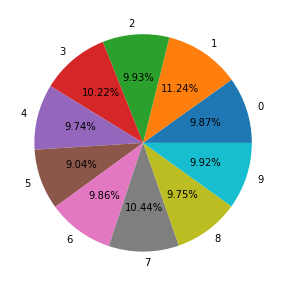


Custom train dataset
The number of samples: 304
The number of samples for each class:  {0: 27, 1: 28, 2: 28, 3: 33, 4: 35, 5: 34, 6: 25, 7: 34, 8: 30, 9: 30}


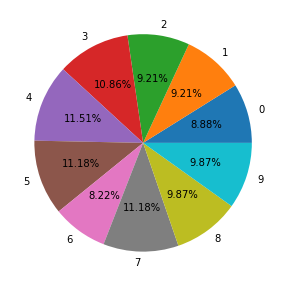


Combined train dataset
The number of samples: 60304
The number of samples for each class:  {0: 5950, 1: 6770, 2: 5986, 3: 6164, 4: 5877, 5: 5455, 6: 5943, 7: 6299, 8: 5881, 9: 5979}


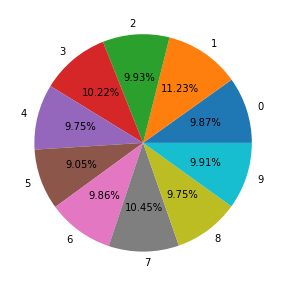

In [7]:
def show_statistic_pie(dataset):
    print(f'The number of samples: {len(dataset)}')
    label_cnt = Counter(dataset[i][1] for i in range(len(dataset)))
    label_cnt = dict(sorted(label_cnt.items()))  # sort by key
    print('The number of samples for each class: ', label_cnt)
    plt.figure(figsize=(5, 5))
    plt.pie(x=label_cnt.values(),
            labels=label_cnt.keys(),
            autopct='%.2f%%')
    plt.show()


print('MNIST train dataset')
show_statistic_pie(mnist_train_dataset)
print()

print('Custom train dataset')
show_statistic_pie(custom_train_dataset)
print()

print('Combined train dataset')
show_statistic_pie(combined_train_dataset)

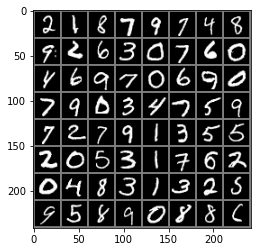

2 1 8 7 9 7 4 8


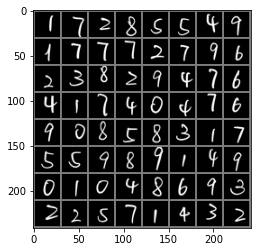

1 7 2 8 5 5 4 9


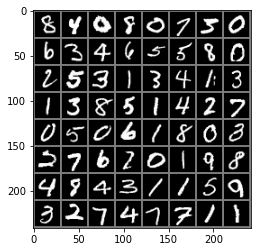

8 4 0 8 0 7 3 0


In [8]:
def visualize_data(dataloader):
    def imshow(img):
        img = img / 2 + 0.5  # Unnormalize the image
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # Get some random images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # Get a batch of training data

    # Show images
    imshow(torchvision.utils.make_grid(images))

    # Print the first 8 labels
    print(' '.join(f'{labels[j]}' for j in range(8)))
    

visualize_data(mnist_train_loader)
visualize_data(custom_loader)
visualize_data(combined_train_loader)

## Define the BP net

### Model

In [9]:
class BP_Net(nn.Module):
    def __init__(self):
        super(BP_Net, self).__init__()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x


mnist_model = BP_Net()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)

combined_model = BP_Net()
combined_criterion = nn.CrossEntropyLoss()
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

### Train

Train on MNIST dataset
Learning rate: 0.001
Batch size: 64
Epochs: 10



Epoch [1/10], Step [100/938], Loss: 0.9276
Epoch [1/10], Step [200/938], Loss: 0.4095
Epoch [1/10], Step [300/938], Loss: 0.5890
Epoch [1/10], Step [400/938], Loss: 0.4639
Epoch [1/10], Step [500/938], Loss: 0.5192
Epoch [1/10], Step [600/938], Loss: 0.5557
Epoch [1/10], Step [700/938], Loss: 0.2394
Epoch [1/10], Step [800/938], Loss: 0.2447
Epoch [1/10], Step [900/938], Loss: 0.2052
Epoch [2/10], Step [100/938], Loss: 0.2811
Epoch [2/10], Step [200/938], Loss: 0.3534
Epoch [2/10], Step [300/938], Loss: 0.5796
Epoch [2/10], Step [400/938], Loss: 0.2093
Epoch [2/10], Step [500/938], Loss: 0.2498
Epoch [2/10], Step [600/938], Loss: 0.2799
Epoch [2/10], Step [700/938], Loss: 0.2507
Epoch [2/10], Step [800/938], Loss: 0.2078
Epoch [2/10], Step [900/938], Loss: 0.1276
Epoch [3/10], Step [100/938], Loss: 0.1750
Epoch [3/10], Step [200/938], Loss: 0.1883
Epoch [3/10], Step [300/938], Loss: 0.3241
Epoch [3/10], Step [400/938], Loss: 0.0994
Epoch [3/10], Step [500/938], Loss: 0.3453
Epoch [3/10

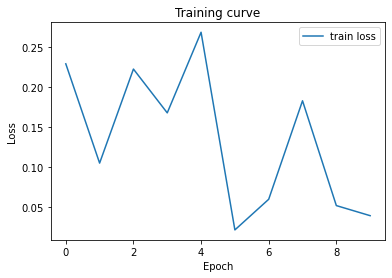




Train on combined dataset
Learning rate: 0.001
Batch size: 64
Epochs: 10

Epoch [1/10], Step [100/943], Loss: 0.5663
Epoch [1/10], Step [200/943], Loss: 0.2820
Epoch [1/10], Step [300/943], Loss: 0.5095
Epoch [1/10], Step [400/943], Loss: 0.3341
Epoch [1/10], Step [500/943], Loss: 0.2725
Epoch [1/10], Step [600/943], Loss: 0.3895
Epoch [1/10], Step [700/943], Loss: 0.3261
Epoch [1/10], Step [800/943], Loss: 0.3603
Epoch [1/10], Step [900/943], Loss: 0.7148
Epoch [2/10], Step [100/943], Loss: 0.2131
Epoch [2/10], Step [200/943], Loss: 0.2548
Epoch [2/10], Step [300/943], Loss: 0.1548
Epoch [2/10], Step [400/943], Loss: 0.2412
Epoch [2/10], Step [500/943], Loss: 0.1421
Epoch [2/10], Step [600/943], Loss: 0.4513
Epoch [2/10], Step [700/943], Loss: 0.1422
Epoch [2/10], Step [800/943], Loss: 0.2870
Epoch [2/10], Step [900/943], Loss: 0.2253
Epoch [3/10], Step [100/943], Loss: 0.2247
Epoch [3/10], Step [200/943], Loss: 0.3729
Epoch [3/10], Step [300/943], Loss: 0.1584
Epoch [3/10], Step [

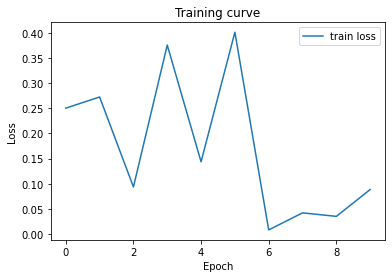

In [10]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    print(f'Learning rate: {learning_rate}')
    print(f'Batch size: {batch_size}')
    print(f'Epochs: {num_epochs}')
    print()
    
    train_loss = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        train_loss.append(loss.item())

    plt.plot(train_loss, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training curve')
    plt.legend()
    plt.show()


print(f'Train on MNIST dataset')
train_model(mnist_model, mnist_criterion, mnist_optimizer, mnist_train_loader, num_epochs)

print('\n\n')

print(f'Train on combined dataset')
train_model(combined_model, combined_criterion, combined_optimizer, combined_train_loader, num_epochs)

## Print confusion matrix

Evaluate MNIST model
Accuracy of the network on the test images: 96.328%


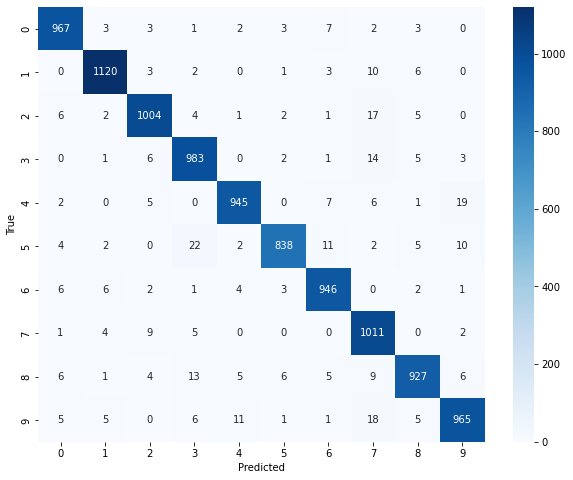

Evaluate combined model
Accuracy of the network on the test images: 96.576%


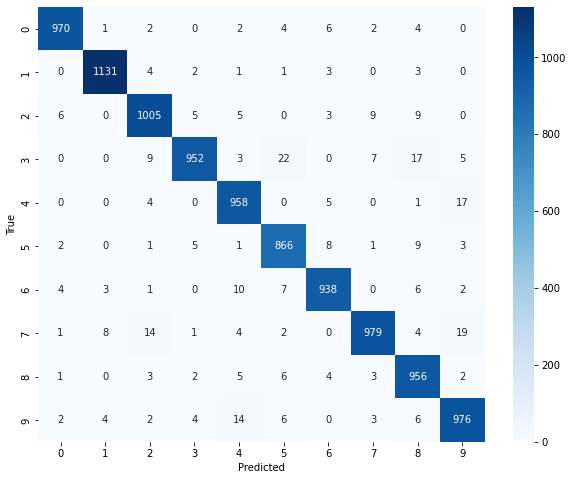

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
            total += labels.size(0)  # Increment the total count
            correct += (predicted == labels).sum()  # Increment the correct count
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
        print(f'Accuracy of the network on the test images: {100 * correct / total:.3f}%')
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        

print(f'Evaluate MNIST model')
evaluate_model(mnist_model, combined_test_loader)
print(f'Evaluate combined model')
evaluate_model(combined_model, combined_test_loader)